In [1]:
%%writefile train_eval.py
import torch
import torch.nn as nn

def train(model, loader, optimizer, criterion, epochs, device='cuda'):
    model.to(device)
    model.train()

    epoch_losses, epoch_top1, epoch_top5 = [], [], []

    for epoch in range(epochs):
        total_loss, correct_top1, correct_top5, total = 0.0, 0, 0, 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            _, pred_top5 = outputs.topk(5, 1)
            total += labels.size(0)
            correct_top1 += (pred_top5[:, 0] == labels).sum().item()
            correct_top5 += pred_top5.eq(labels.view(-1, 1)).sum().item()

        avg_loss = total_loss / total
        top1_acc = 100 * correct_top1 / total
        top5_acc = 100 * correct_top5 / total

        epoch_losses.append(avg_loss)
        epoch_top1.append(top1_acc)
        epoch_top5.append(top5_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Top-1: {top1_acc:.2f}% | Top-5: {top5_acc:.2f}%")

    return epoch_losses, epoch_top1, epoch_top5


def evaluate(model, loader, criterion, device='cuda'):
    model.to(device)
    model.eval()
    total_loss = 0.0
    correct_top1, correct_top5, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, pred_top5 = outputs.topk(5, dim=1, largest=True, sorted=True)
            total += labels.size(0)
            correct_top1 += (pred_top5[:, 0] == labels).sum().item()
            correct_top5 += pred_top5.eq(labels.view(-1, 1)).sum().item()

    avg_loss = total_loss / total
    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total

    print(f"Eval Loss: {avg_loss:.4f} | Top-1 Acc: {top1_acc:.2f}% | Top-5 Acc: {top5_acc:.2f}%")
    return avg_loss, top1_acc, top5_acc


Overwriting train_eval.py


In [2]:
%%writefile data_utils.py
import torch
from torchvision import datasets, transforms

def get_cifar100_loaders(batch_size=128, num_workers=2):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader


Overwriting data_utils.py


In [3]:
%%writefile model.py
import torch
import torch.nn as nn

def get_model(model_name='vgg16_bn', pretrained=True, num_classes=100):
    valid_models = ['vgg11_bn', 'vgg16_bn']
    if model_name not in valid_models:
        raise ValueError(f"model_name must be one of {valid_models}")
    model = torch.hub.load(
        'chenyaofo/pytorch-cifar-models',
        f'cifar100_{model_name}',
        pretrained=pretrained
    )
    return model

Overwriting model.py


In [4]:
from train_eval import train, evaluate
from model import get_model
from data_utils import get_cifar100_loaders
import torch.nn as nn
import torch.optim as optim

train_loader, test_loader = get_cifar100_loaders(batch_size=128)
model = get_model('vgg16_bn', pretrained=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, train_top1, train_top5 = train(model, train_loader, optimizer, criterion, epochs=20)
evaluate(model, test_loader, criterion)


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch [1/20] | Loss: 4.3659 | Top-1: 2.36% | Top-5: 10.88%
Epoch [2/20] | Loss: 3.9704 | Top-1: 5.60% | Top-5: 23.23%
Epoch [3/20] | Loss: 3.7059 | Top-1: 9.18% | Top-5: 32.51%
Epoch [4/20] | Loss: 3.5236 | Top-1: 11.79% | Top-5: 38.41%
Epoch [5/20] | Loss: 3.3849 | Top-1: 14.03% | Top-5: 42.85%
Epoch [6/20] | Loss: 3.2506 | Top-1: 16.32% | Top-5: 46.76%
Epoch [7/20] | Loss: 3.0999 | Top-1: 18.76% | Top-5: 51.03%
Epoch [8/20] | Loss: 2.9481 | Top-1: 21.99% | Top-5: 55.51%
Epoch [9/20] | Loss: 2.8046 | Top-1: 25.32% | Top-5: 59.48%
Epoch [10/20] | Loss: 2.6841 | Top-1: 28.02% | Top-5: 62.70%
Epoch [11/20] | Loss: 2.5722 | Top-1: 30.35% | Top-5: 65.42%
Epoch [12/20] | Loss: 2.4624 | Top-1: 33.22% | Top-5: 67.75%
Epoch [13/20] | Loss: 2.3814 | Top-1: 34.98% | Top-5: 69.58%
Epoch [14/20] | Loss: 2.2926 | Top-1: 37.06% | Top-5: 71.48%
Epoch [15/20] | Loss: 2.2027 | Top-1: 39.40% | Top-5: 73.17%
Epoch [16/20] | Loss: 2.1452 | Top-1: 41.35% | Top-5: 74.43%
Epoch [17/20] | Loss: 2.0815 | Top-1

(2.0699958656311037, 44.98, 75.16)

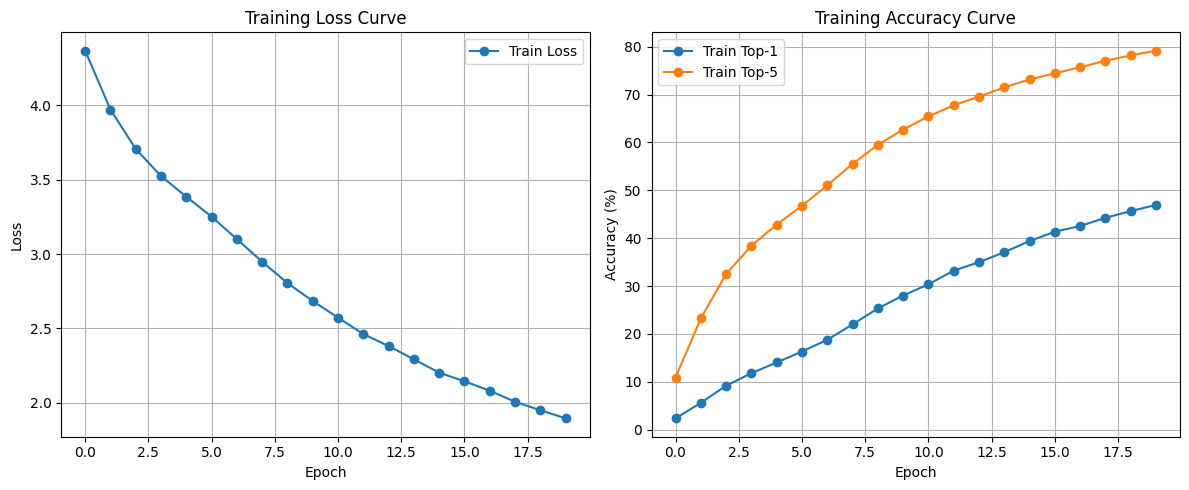

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_top1, label='Train Top-1', marker='o')
plt.plot(train_top5, label='Train Top-5', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
%%writefile train_kd.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from typing import Optional

class KDLoss(nn.Module):
    def __init__(self, ce_criterion, alpha=0.6, T=3.0):
        super(KDLoss, self).__init__()
        self.ce_criterion = ce_criterion
        self.alpha = alpha
        self.T = T

    def forward(self, teacher_logits, student_logits, labels):
        ce_loss = self.ce_criterion(student_logits, labels)
        log_ps = F.log_softmax(student_logits / self.T, dim=1)
        pt = F.softmax(teacher_logits / self.T, dim=1)
        kd_loss = F.kl_div(log_ps, pt, reduction='batchmean') * (self.T ** 2)
        total = (1.0 - self.alpha) * ce_loss + self.alpha * kd_loss
        return total, ce_loss.detach(), kd_loss.detach()

def train_kd(student, teacher, train_loader, optimizer, kd_criterion, epochs,
             device='cuda', scheduler=None, save_path: Optional[str]=None, log_every: Optional[int]=None):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    teacher.to(device)
    student.to(device)

    teacher.eval()
    student.train()

    # For plotting curves
    epoch_losses = []
    epoch_ce_losses = []
    epoch_kd_losses = []
    epoch_top1 = []
    epoch_top5 = []

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        running_loss = 0.0
        running_ce = 0.0
        running_kd = 0.0
        total_examples = 0
        correct_top1 = 0
        correct_top5 = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)

            # Teacher forward (no grad)
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Student forward
            student_logits = student(inputs)

            # KD loss
            total_loss, ce_val, kd_val = kd_criterion(teacher_logits, student_logits, labels)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Statistics
            running_loss += total_loss.item() * batch_size
            running_ce += ce_val.item() * batch_size
            running_kd += kd_val.item() * batch_size
            total_examples += batch_size

            # Top-1 / Top-5
            _, pred_top5 = student_logits.topk(5, dim=1, largest=True, sorted=True)
            correct_top1 += (pred_top5[:, 0] == labels).sum().item()
            correct_top5 += pred_top5.eq(labels.view(-1, 1)).sum().item()

            if log_every and (batch_idx + 1) % log_every == 0:
                avg_loss_sofar = running_loss / total_examples
                avg_ce_sofar = running_ce / total_examples
                avg_kd_sofar = running_kd / total_examples
                top1_sofar = 100.0 * correct_top1 / total_examples
                top5_sofar = 100.0 * correct_top5 / total_examples
                print(f"Epoch {epoch} Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss {avg_loss_sofar:.4f} (CE {avg_ce_sofar:.4f}, KD {avg_kd_sofar:.4f}) | "
                      f"Top1 {top1_sofar:.2f}% Top5 {top5_sofar:.2f}%")

        # Scheduler step
        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass

        # Per-epoch metrics
        avg_loss = running_loss / total_examples
        avg_ce = running_ce / total_examples
        avg_kd = running_kd / total_examples
        top1 = 100.0 * correct_top1 / total_examples
        top5 = 100.0 * correct_top5 / total_examples

        epoch_losses.append(avg_loss)
        epoch_ce_losses.append(avg_ce)
        epoch_kd_losses.append(avg_kd)
        epoch_top1.append(top1)
        epoch_top5.append(top5)

        epoch_time = time.time() - epoch_start
        print("-" * 90)
        print(f"Epoch {epoch}/{epochs} finished in {epoch_time:.1f}s | "
              f"Avg Loss: {avg_loss:.4f} | CE: {avg_ce:.4f} | KD: {avg_kd:.4f} | "
              f"Train Top1: {top1:.2f}% Top5: {top5:.2f}%")
        print("-" * 90)

        # Optional checkpoint
        if save_path:
            ckpt = {
                'epoch': epoch,
                'student_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }
            torch.save(ckpt, f"{save_path}.epoch{epoch}.pth")

    # Final save
    if save_path:
        torch.save({'student_state_dict': student.state_dict()}, save_path)
        print(f"Saved final student checkpoint to: {save_path}")

    return student, epoch_losses, epoch_ce_losses, epoch_kd_losses, epoch_top1, epoch_top5

Overwriting train_kd.py


In [7]:
from data_utils import get_cifar100_loaders
from model import get_model
from train_eval import evaluate
from train_kd import train_kd, KDLoss
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_cifar100_loaders(batch_size=128, num_workers=2)

teacher = get_model('vgg16_bn', pretrained=True, num_classes=100)
student = get_model('vgg11_bn', pretrained=False, num_classes=100)

teacher.to(device)
student.to(device)

ce_criterion = nn.CrossEntropyLoss()
kd_criterion = KDLoss(ce_criterion, alpha=0.6, T=3.0)
optimizer = optim.Adam(student.parameters(), lr=1e-4)

student, epoch_losses, epoch_ce, epoch_kd, epoch_top1, epoch_top5 = train_kd(student=student,
                   teacher=teacher,
                   train_loader=train_loader,
                   optimizer=optimizer,
                   kd_criterion=kd_criterion,
                   epochs=20,
                   device=device,
                   save_path='student_kd_final.pth',
                   log_every=20)

avg_loss, top1, top5 = evaluate(student, test_loader, ce_criterion, device=device)
print(f"Test -> Loss: {avg_loss:.4f}, Top1: {top1:.2f}%, Top5: {top5:.2f}%")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch 1 Batch 20/391 | Loss 16.2115 (CE 4.6034, KD 23.9503) | Top1 1.41% Top5 5.78%
Epoch 1 Batch 40/391 | Loss 16.1931 (CE 4.5992, KD 23.9223) | Top1 1.41% Top5 5.96%
Epoch 1 Batch 60/391 | Loss 16.1445 (CE 4.5832, KD 23.8520) | Top1 1.51% Top5 6.43%
Epoch 1 Batch 80/391 | Loss 16.0598 (CE 4.5679, KD 23.7211) | Top1 1.60% Top5 7.17%
Epoch 1 Batch 100/391 | Loss 16.0033 (CE 4.5660, KD 23.6282) | Top1 1.68% Top5 7.61%
Epoch 1 Batch 120/391 | Loss 15.9618 (CE 4.5545, KD 23.5667) | Top1 1.74% Top5 7.86%
Epoch 1 Batch 140/391 | Loss 15.9146 (CE 4.5375, KD 23.4994) | Top1 1.77% Top5 8.20%
Epoch 1 Batch 160/391 | Loss 15.8539 (CE 4.5202, KD 23.4097) | Top1 1.81% Top5 8.48%
Epoch 1 Batch 180/391 | Loss 15.7826 (CE 4.5048, KD 23.3010) | Top1 1.93% Top5 8.80%
Epoch 1 Batch 200/391 | Loss 15.7184 (CE 4.4925, KD 23.2023) | Top1 2.07% Top5 9.22%
Epoch 1 Batch 220/391 | Loss 15.6633 (CE 4.4806, KD 23.1185) | Top1 2.07% Top5 9.47%
Epoch 1 Batch 240/391 | Loss 15.6107 (CE 4.4693, KD 23.0384) | Top1 2

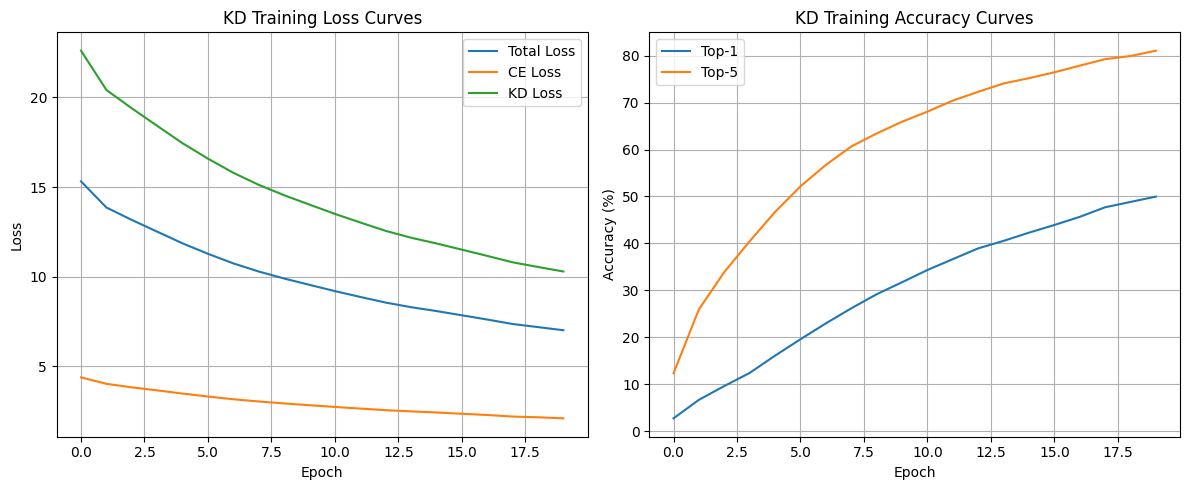

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Total Loss')
plt.plot(epoch_ce, label='CE Loss')
plt.plot(epoch_kd, label='KD Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KD Training Loss Curves')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(epoch_top1, label='Top-1')
plt.plot(epoch_top5, label='Top-5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('KD Training Accuracy Curves')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()